## Функция отрисовки датасета

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
def show():
    plt.figure(1)
    plt.clf()

    colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        plt.plot(x[my_members, 0], x[my_members, 1], col + ".")
        plt.plot(
            cluster_center[0],
            cluster_center[1],
            "o",
            markerfacecolor=col,
            markeredgecolor="k",
            markersize=14,
        )
    plt.title("Estimated number of clusters: %d" % n_clusters_)
    plt.show()
    print(cluster_centers)
    print(dloss(cluster_centers,x,y))

# Простой градиентный спуск

In [2]:
def my_gd(f, df, X0, lr = 0.001, N_it = 100, data = False, labls = False):
    model = X0.copy()
    for i in range(N_it):
        if type(data) == bool:
            model -= lr * df(model)
        else:
            model += lr * df(model, data, labls)
    return model

# Функции

### Простой х^2

In [3]:
def f(x):
    return x[0]**2 + x[1]**2
def df(x):
    return 2*x

### Функция Розенброка

In [4]:
def f1(x):
    return ((1 - x[0]) ** 2 + 100 * (x[1] - x[0] * x[0]) ** 2 )
def df1(x):
    return np.array([2 * x[0] - 2 + 400 * x[0] * (x[0] * x[0] - x[1]),
                      200 * (x[1] - x[0] * x[0])])

### Loss как сумма квадратов ошибки

In [5]:
def loss(centers,x,y):
    Loss = np.zeros(centers.shape, dtype = np.float64)
    for i in range(len(x)):
        Loss[y[i]] += (x[i]-centers[y[i]])**2
    return Loss
def dloss(centers,x,y):
    Loss = np.zeros(centers.shape, dtype = np.float64)
    for i in range(len(x)):
        Loss[y[i]] += 2*(x[i]-centers[y[i]])
    return Loss

## Работа простого градиентного спуска 

### На х^2

In [6]:
X0 = np.array([100.0,100.0])
param = my_gd(f, df, X0, lr = 0.1)
print(X0, f(X0))
print(param, f(param))

[100. 100.] 20000.0
[2.03703598e-08 2.03703598e-08] 8.299031137761998e-16


### На функции Розенброка

In [7]:
X0 = np.array([2.0,2.0])
param = my_gd(f1, df1, X0, lr = 0.001)
print(X0, f1(X0))
print(param, f1(param))

[2. 2.] 401.0
[1.26925928 1.61193745] 0.0725848935590672


# Усовершенствованый градиентный спуск

## Моментный

In [8]:
def my_sgd_momentow(f, df, X0, data = False, labls = False, lr = 0.01, N_it = 100, bath = 10, gamma = 0.1):
    # по инерции продолжает двигаться
    model = X0.copy()
    loss_old = np.zeros(X0.shape, dtype = np.float64)
    for i in range(N_it):
        loss  = np.zeros(X0.shape, dtype = np.float64)
        if type(data) != bool:
            for j in range(int(len(data) / bath)):
                loss += df(model, data[j*bath:j*bath+bath], labls[j*bath:j*bath+bath])
                loss_old = gamma * loss_old + lr * loss
                model += loss_old
        else:
            loss -= df(model)
            loss_old = gamma * loss_old + lr * loss
            model += loss_old
    return model



## Адаптивный

In [9]:
def my_sgd_adaptiv(f, df, X0, data = False, labls = False, lr = 0.1, N_it = 100, bath = 10, gamma = 0.5):
    # Движется в 1 направлении охотнее других
    # Adagrad
    model = X0.copy()
    Gt = np.zeros(X0.shape, dtype = np.float64)
    for i in range(N_it):
        loss  = np.zeros(X0.shape, dtype = np.float64)
        if type(data) != bool:
            for j in range(int(len(data) / bath)):
                loss += df(model, data[j*bath:j*bath+bath], labls[j*bath:j*bath+bath])
                Gt = gamma * Gt + loss**2
                model += (lr/(Gt**(1/2))) * loss
        else:
            loss -= df(model)
            Gt = gamma * Gt + loss**2
            model += (lr/(Gt**(1/2))) * loss
    return model

# Пример работы

## С функцией

### Моментный

In [10]:
X0 = np.array([2.0,2.0])
param = my_sgd_momentow(f1, df1, X0, lr = 0.0001, gamma = 0.9, N_it = 1000)
print(X0, f1(X0))
print(param, f1(param))

[2. 2.] 401.0
[1.10240432 1.21568058] 0.010501490330569246


### Адаптивный

In [11]:
X0 = np.array([2.0,2.0])
param = my_sgd_adaptiv(f1, df1, X0, lr = 0.01, gamma = 0.9, N_it = 1000)
print(X0, f1(X0))
print(param, f1(param))

[2. 2.] 401.0
[1.40083347 1.95743435] 0.163068514513875


## С датасетом

### Исходные данные

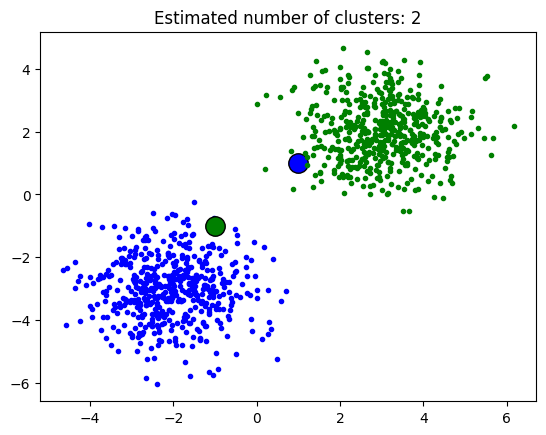

[[ 1.  1.]
 [-1. -1.]]
[[-3065.36568811 -4025.14772687]
 [ 4021.89271934  3005.34116129]]


In [12]:
from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=1000, centers=[[-2,-3],[3,2]], n_features=2,random_state=0)
centers = np.array([[1, 1], [-1, -1]], dtype = np.float64)
cluster_centers = centers
n_clusters_ = len(centers)
labels = y
show()

### Работа простого GD

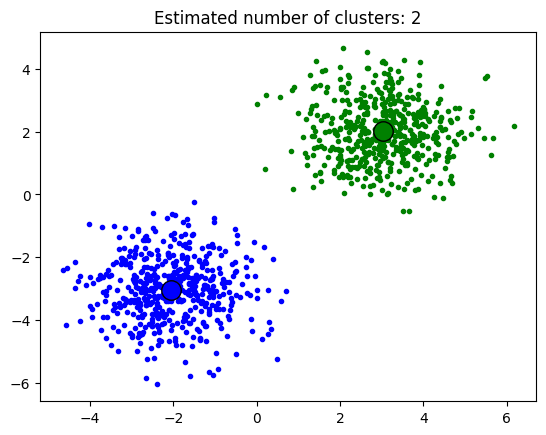

[[-2.06536569 -3.02514773]
 [ 3.02189272  2.00534116]]
[[-2.01616501e-13 -3.46389584e-14]
 [ 9.68114477e-14  1.55875313e-13]]


In [13]:
cluster_centers = my_gd(loss, dloss, centers, lr = 0.001, N_it = 100, data = x, labls = y)
show()

### Работа моментного метода

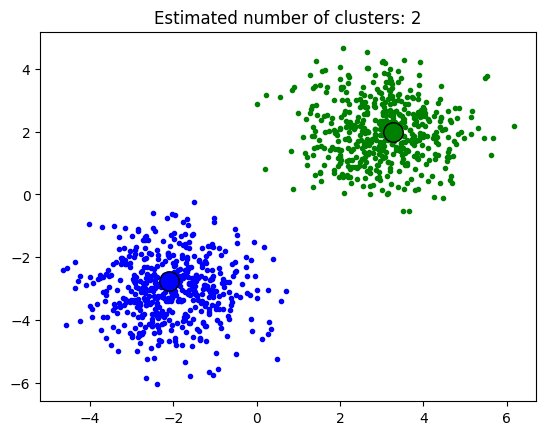

[[-2.11367973 -2.74009151]
 [ 3.26082141  1.9873218 ]]
[[  48.31404597 -285.05622184]
 [-238.92868878   18.01935697]]


In [14]:
centers = np.array([[1, 1], [-1, -1]], dtype = np.float64)
cluster_centers = my_sgd_momentow(loss, dloss, centers, x, y, lr = 0.001, N_it = 100, gamma = 0.1)
show()

### Работа адаптивного метода

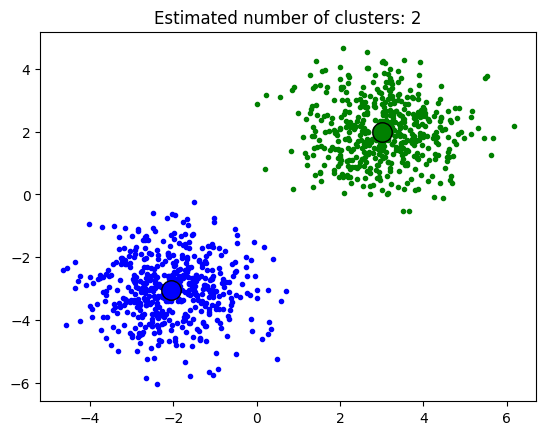

[[-2.064 -3.028]
 [ 3.016  1.996]]
[[-1.36568811  2.85227313]
 [ 5.89271934  9.34116129]]


In [15]:
centers = np.array([[1, 1], [-1, -1]], dtype = np.float64)
cluster_centers = my_sgd_adaptiv(loss, dloss, centers, x, y, lr = 0.001, N_it = 100, gamma = 0.0)
show()